In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm 

REBUILD_DATA = True

In [2]:
class cells():
    IMG_SIZE = 50
    PARASITIZED = "Parasitized"
    UNINFECTED = "Uninfected"
    LABELS = {PARASITIZED : 0, UNINFECTED : 1}
    
    training_data = []
    badcount = 0
    goodcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.PARASITIZED:
                        self.badcount += 1
                    elif label == self.UNINFECTED:
                        self.goodcount += 1
                        
                except Exception as e:
                    pass
                    #print(str(e))
                    
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        
        print("Parasitized: ", self.badcount)
        print("Uninfected: ", self.goodcount)


In [ ]:
if REBUILD_DATA:
    yay = cells()
    yay.make_training_data()

Parasitized


  0%|          | 6/13780 [00:00<04:02, 56.83it/s]

Uninfected


  6%|▌         | 793/13780 [00:09<02:31, 85.93it/s]

In [7]:
training_data = np.load("training_data.npy", allow_pickle=True)

In [8]:
print(len(training_data))

27558


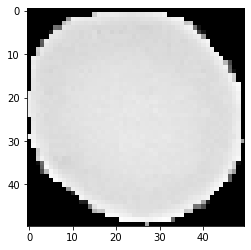

In [10]:
import matplotlib.pyplot as plt

plt.imshow(training_data[1][0], cmap = 'gray')
plt.show()

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [21]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(50, 50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512,2)
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2,))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2,))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2,))
        
        print(x[0].shape)
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim = 1)
    

net = Net()
            

torch.Size([128, 2, 2])


In [22]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr = 0.001)

loss_function = nn.MSELoss() 

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X) * VAL_PCT)

print(val_size)

2755


In [23]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

24803
2755


In [26]:
BATCH_SIZE = 100

EPOCHS = 3

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        #print(i, i+BATCH_SIZE)
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
        batch_y = train_y[i:i+BATCH_SIZE]
        
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
print(loss)

  0%|          | 0/249 [00:00<?, ?it/s]

torch.Size([128, 2, 2])


  0%|          | 1/249 [00:00<02:58,  1.39it/s]

torch.Size([128, 2, 2])


  1%|          | 2/249 [00:01<02:42,  1.52it/s]

torch.Size([128, 2, 2])


  1%|          | 3/249 [00:01<02:34,  1.59it/s]

torch.Size([128, 2, 2])


  2%|▏         | 4/249 [00:02<02:26,  1.67it/s]

torch.Size([128, 2, 2])


  2%|▏         | 5/249 [00:02<02:17,  1.78it/s]

torch.Size([128, 2, 2])


  2%|▏         | 6/249 [00:03<02:08,  1.88it/s]

torch.Size([128, 2, 2])


  3%|▎         | 7/249 [00:03<02:04,  1.95it/s]

torch.Size([128, 2, 2])


  3%|▎         | 8/249 [00:04<02:04,  1.94it/s]

torch.Size([128, 2, 2])


  4%|▎         | 9/249 [00:04<02:01,  1.98it/s]

torch.Size([128, 2, 2])


  4%|▍         | 10/249 [00:05<01:58,  2.01it/s]

torch.Size([128, 2, 2])


  4%|▍         | 11/249 [00:05<01:55,  2.06it/s]

torch.Size([128, 2, 2])


  5%|▍         | 12/249 [00:06<01:54,  2.07it/s]

torch.Size([128, 2, 2])


  5%|▌         | 13/249 [00:06<01:52,  2.10it/s]

torch.Size([128, 2, 2])


  6%|▌         | 14/249 [00:07<01:53,  2.06it/s]

torch.Size([128, 2, 2])


  6%|▌         | 15/249 [00:07<01:59,  1.96it/s]

torch.Size([128, 2, 2])


  6%|▋         | 16/249 [00:08<02:01,  1.91it/s]

torch.Size([128, 2, 2])


  7%|▋         | 17/249 [00:08<02:00,  1.93it/s]

torch.Size([128, 2, 2])


  7%|▋         | 18/249 [00:09<01:59,  1.94it/s]

torch.Size([128, 2, 2])


  8%|▊         | 19/249 [00:09<01:55,  1.99it/s]

torch.Size([128, 2, 2])


  8%|▊         | 20/249 [00:10<01:51,  2.05it/s]

torch.Size([128, 2, 2])


  8%|▊         | 21/249 [00:10<01:49,  2.08it/s]

torch.Size([128, 2, 2])


  9%|▉         | 22/249 [00:11<01:47,  2.11it/s]

torch.Size([128, 2, 2])


  9%|▉         | 23/249 [00:11<01:49,  2.06it/s]

torch.Size([128, 2, 2])


 10%|▉         | 24/249 [00:12<01:49,  2.05it/s]

torch.Size([128, 2, 2])


 10%|█         | 25/249 [00:12<01:53,  1.97it/s]

torch.Size([128, 2, 2])


 10%|█         | 26/249 [00:13<01:50,  2.02it/s]

torch.Size([128, 2, 2])


 11%|█         | 27/249 [00:13<01:52,  1.97it/s]

torch.Size([128, 2, 2])


 11%|█         | 28/249 [00:14<01:55,  1.92it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 29/249 [00:14<01:51,  1.98it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 30/249 [00:15<01:54,  1.91it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 31/249 [00:15<01:55,  1.88it/s]

torch.Size([128, 2, 2])


 13%|█▎        | 32/249 [00:16<01:57,  1.84it/s]

torch.Size([128, 2, 2])


 13%|█▎        | 33/249 [00:16<02:00,  1.80it/s]

torch.Size([128, 2, 2])


 14%|█▎        | 34/249 [00:17<01:59,  1.80it/s]

torch.Size([128, 2, 2])


 14%|█▍        | 35/249 [00:17<01:54,  1.88it/s]

torch.Size([128, 2, 2])


 14%|█▍        | 36/249 [00:18<01:53,  1.88it/s]

torch.Size([128, 2, 2])


 15%|█▍        | 37/249 [00:19<01:57,  1.80it/s]

torch.Size([128, 2, 2])


 15%|█▌        | 38/249 [00:19<01:57,  1.80it/s]

torch.Size([128, 2, 2])


 16%|█▌        | 39/249 [00:20<01:53,  1.86it/s]

torch.Size([128, 2, 2])


 16%|█▌        | 40/249 [00:20<01:50,  1.88it/s]

torch.Size([128, 2, 2])


 16%|█▋        | 41/249 [00:21<01:54,  1.82it/s]

torch.Size([128, 2, 2])


 17%|█▋        | 42/249 [00:21<01:57,  1.77it/s]

torch.Size([128, 2, 2])


 17%|█▋        | 43/249 [00:22<02:02,  1.69it/s]

torch.Size([128, 2, 2])


 18%|█▊        | 44/249 [00:23<02:06,  1.62it/s]

torch.Size([128, 2, 2])


 18%|█▊        | 45/249 [00:23<02:04,  1.64it/s]

torch.Size([128, 2, 2])


 18%|█▊        | 46/249 [00:24<02:02,  1.66it/s]

torch.Size([128, 2, 2])


 19%|█▉        | 47/249 [00:25<02:14,  1.51it/s]

torch.Size([128, 2, 2])


 19%|█▉        | 48/249 [00:25<02:05,  1.61it/s]

torch.Size([128, 2, 2])


 20%|█▉        | 49/249 [00:26<01:56,  1.71it/s]

torch.Size([128, 2, 2])


 20%|██        | 50/249 [00:26<01:57,  1.69it/s]

torch.Size([128, 2, 2])


 20%|██        | 51/249 [00:27<02:14,  1.47it/s]

torch.Size([128, 2, 2])


 21%|██        | 52/249 [00:28<02:18,  1.42it/s]

torch.Size([128, 2, 2])


 21%|██▏       | 53/249 [00:29<02:27,  1.33it/s]

torch.Size([128, 2, 2])


 22%|██▏       | 54/249 [00:30<02:24,  1.35it/s]

torch.Size([128, 2, 2])


 22%|██▏       | 55/249 [00:30<02:14,  1.44it/s]

torch.Size([128, 2, 2])


 22%|██▏       | 56/249 [00:31<02:19,  1.38it/s]

torch.Size([128, 2, 2])


 23%|██▎       | 57/249 [00:32<02:44,  1.17it/s]

torch.Size([128, 2, 2])


 23%|██▎       | 58/249 [00:33<02:28,  1.29it/s]

torch.Size([128, 2, 2])


 24%|██▎       | 59/249 [00:33<02:15,  1.40it/s]

torch.Size([128, 2, 2])


 24%|██▍       | 60/249 [00:34<02:05,  1.50it/s]

torch.Size([128, 2, 2])


 24%|██▍       | 61/249 [00:34<01:56,  1.61it/s]

torch.Size([128, 2, 2])


 25%|██▍       | 62/249 [00:35<01:51,  1.68it/s]

torch.Size([128, 2, 2])


 25%|██▌       | 63/249 [00:35<01:45,  1.77it/s]

torch.Size([128, 2, 2])


 26%|██▌       | 64/249 [00:36<01:42,  1.81it/s]

torch.Size([128, 2, 2])


 26%|██▌       | 65/249 [00:36<01:43,  1.78it/s]

torch.Size([128, 2, 2])


 27%|██▋       | 66/249 [00:37<01:42,  1.79it/s]

torch.Size([128, 2, 2])


 27%|██▋       | 67/249 [00:38<01:39,  1.82it/s]

torch.Size([128, 2, 2])


 27%|██▋       | 68/249 [00:38<01:36,  1.88it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 69/249 [00:39<01:35,  1.89it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 70/249 [00:39<01:33,  1.92it/s]

torch.Size([128, 2, 2])


 29%|██▊       | 71/249 [00:40<01:32,  1.92it/s]

torch.Size([128, 2, 2])


 29%|██▉       | 72/249 [00:40<01:30,  1.96it/s]

torch.Size([128, 2, 2])


 29%|██▉       | 73/249 [00:41<01:30,  1.95it/s]

torch.Size([128, 2, 2])


 30%|██▉       | 74/249 [00:41<01:31,  1.90it/s]

torch.Size([128, 2, 2])


 30%|███       | 75/249 [00:42<01:31,  1.91it/s]

torch.Size([128, 2, 2])


 31%|███       | 76/249 [00:42<01:29,  1.93it/s]

torch.Size([128, 2, 2])


 31%|███       | 77/249 [00:43<01:28,  1.95it/s]

torch.Size([128, 2, 2])


 31%|███▏      | 78/249 [00:43<01:27,  1.96it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 79/249 [00:44<01:26,  1.96it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 80/249 [00:44<01:29,  1.89it/s]

torch.Size([128, 2, 2])


 33%|███▎      | 81/249 [00:45<01:32,  1.83it/s]

torch.Size([128, 2, 2])


 33%|███▎      | 82/249 [00:45<01:31,  1.82it/s]

torch.Size([128, 2, 2])


 33%|███▎      | 83/249 [00:46<01:30,  1.82it/s]

torch.Size([128, 2, 2])


 34%|███▎      | 84/249 [00:47<01:30,  1.82it/s]

torch.Size([128, 2, 2])


 34%|███▍      | 85/249 [00:47<01:29,  1.83it/s]

torch.Size([128, 2, 2])


 35%|███▍      | 86/249 [00:48<01:28,  1.84it/s]

torch.Size([128, 2, 2])


 35%|███▍      | 87/249 [00:48<01:28,  1.83it/s]

torch.Size([128, 2, 2])


 35%|███▌      | 88/249 [00:49<01:28,  1.83it/s]

torch.Size([128, 2, 2])


 36%|███▌      | 89/249 [00:49<01:28,  1.81it/s]

torch.Size([128, 2, 2])


 36%|███▌      | 90/249 [00:50<01:28,  1.80it/s]

torch.Size([128, 2, 2])


 37%|███▋      | 91/249 [00:50<01:29,  1.77it/s]

torch.Size([128, 2, 2])


 37%|███▋      | 92/249 [00:51<01:29,  1.76it/s]

torch.Size([128, 2, 2])


 37%|███▋      | 93/249 [00:52<01:28,  1.77it/s]

torch.Size([128, 2, 2])


 38%|███▊      | 94/249 [00:52<01:28,  1.76it/s]

torch.Size([128, 2, 2])


 38%|███▊      | 95/249 [00:53<01:27,  1.76it/s]

torch.Size([128, 2, 2])


 39%|███▊      | 96/249 [00:53<01:25,  1.80it/s]

torch.Size([128, 2, 2])


 39%|███▉      | 97/249 [00:54<01:23,  1.81it/s]

torch.Size([128, 2, 2])


 39%|███▉      | 98/249 [00:54<01:22,  1.83it/s]

torch.Size([128, 2, 2])


 40%|███▉      | 99/249 [00:55<01:20,  1.86it/s]

torch.Size([128, 2, 2])


 40%|████      | 100/249 [00:55<01:20,  1.85it/s]

torch.Size([128, 2, 2])


 41%|████      | 101/249 [00:56<01:28,  1.67it/s]

torch.Size([128, 2, 2])


 41%|████      | 102/249 [00:57<01:26,  1.70it/s]

torch.Size([128, 2, 2])


 41%|████▏     | 103/249 [00:57<01:23,  1.74it/s]

torch.Size([128, 2, 2])


 42%|████▏     | 104/249 [00:58<01:22,  1.76it/s]

torch.Size([128, 2, 2])


 42%|████▏     | 105/249 [00:58<01:20,  1.79it/s]

torch.Size([128, 2, 2])


 43%|████▎     | 106/249 [00:59<01:19,  1.81it/s]

torch.Size([128, 2, 2])


 43%|████▎     | 107/249 [00:59<01:17,  1.84it/s]

torch.Size([128, 2, 2])


 43%|████▎     | 108/249 [01:00<01:16,  1.84it/s]

torch.Size([128, 2, 2])


 44%|████▍     | 109/249 [01:00<01:15,  1.85it/s]

torch.Size([128, 2, 2])


 44%|████▍     | 110/249 [01:01<01:13,  1.89it/s]

torch.Size([128, 2, 2])


 45%|████▍     | 111/249 [01:01<01:14,  1.86it/s]

torch.Size([128, 2, 2])


 45%|████▍     | 112/249 [01:02<01:12,  1.88it/s]

torch.Size([128, 2, 2])


 45%|████▌     | 113/249 [01:03<01:12,  1.88it/s]

torch.Size([128, 2, 2])


 46%|████▌     | 114/249 [01:03<01:11,  1.88it/s]

torch.Size([128, 2, 2])


 46%|████▌     | 115/249 [01:04<01:16,  1.75it/s]

torch.Size([128, 2, 2])


 47%|████▋     | 116/249 [01:04<01:14,  1.79it/s]

torch.Size([128, 2, 2])


 47%|████▋     | 117/249 [01:05<01:13,  1.81it/s]

torch.Size([128, 2, 2])


 47%|████▋     | 118/249 [01:05<01:11,  1.84it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 119/249 [01:06<01:09,  1.86it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 120/249 [01:06<01:09,  1.87it/s]

torch.Size([128, 2, 2])


 49%|████▊     | 121/249 [01:07<01:08,  1.87it/s]

torch.Size([128, 2, 2])


 49%|████▉     | 122/249 [01:07<01:08,  1.86it/s]

torch.Size([128, 2, 2])


 49%|████▉     | 123/249 [01:08<01:07,  1.86it/s]

torch.Size([128, 2, 2])


 50%|████▉     | 124/249 [01:09<01:10,  1.76it/s]

torch.Size([128, 2, 2])


 50%|█████     | 125/249 [01:09<01:11,  1.72it/s]

torch.Size([128, 2, 2])


 51%|█████     | 126/249 [01:10<01:10,  1.75it/s]

torch.Size([128, 2, 2])


 51%|█████     | 127/249 [01:10<01:08,  1.79it/s]

torch.Size([128, 2, 2])


 51%|█████▏    | 128/249 [01:11<01:07,  1.80it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 129/249 [01:11<01:05,  1.83it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 130/249 [01:12<01:04,  1.86it/s]

torch.Size([128, 2, 2])


 53%|█████▎    | 131/249 [01:12<01:03,  1.87it/s]

torch.Size([128, 2, 2])


 53%|█████▎    | 132/249 [01:13<01:02,  1.86it/s]

torch.Size([128, 2, 2])


 53%|█████▎    | 133/249 [01:14<01:02,  1.86it/s]

torch.Size([128, 2, 2])


 54%|█████▍    | 134/249 [01:14<01:02,  1.83it/s]

torch.Size([128, 2, 2])


 54%|█████▍    | 135/249 [01:15<01:02,  1.83it/s]

torch.Size([128, 2, 2])


 55%|█████▍    | 136/249 [01:15<01:01,  1.83it/s]

torch.Size([128, 2, 2])


 55%|█████▌    | 137/249 [01:16<01:01,  1.82it/s]

torch.Size([128, 2, 2])


 55%|█████▌    | 138/249 [01:16<01:00,  1.85it/s]

torch.Size([128, 2, 2])


 56%|█████▌    | 139/249 [01:17<01:00,  1.83it/s]

torch.Size([128, 2, 2])


 56%|█████▌    | 140/249 [01:17<00:59,  1.84it/s]

torch.Size([128, 2, 2])


 57%|█████▋    | 141/249 [01:18<00:58,  1.84it/s]

torch.Size([128, 2, 2])


 57%|█████▋    | 142/249 [01:18<00:58,  1.82it/s]

torch.Size([128, 2, 2])


 57%|█████▋    | 143/249 [01:19<00:57,  1.83it/s]

torch.Size([128, 2, 2])


 58%|█████▊    | 144/249 [01:20<00:58,  1.81it/s]

torch.Size([128, 2, 2])


 58%|█████▊    | 145/249 [01:20<00:56,  1.83it/s]

torch.Size([128, 2, 2])


 59%|█████▊    | 146/249 [01:21<00:56,  1.83it/s]

torch.Size([128, 2, 2])


 59%|█████▉    | 147/249 [01:21<00:55,  1.83it/s]

torch.Size([128, 2, 2])


 59%|█████▉    | 148/249 [01:22<00:55,  1.82it/s]

torch.Size([128, 2, 2])


 60%|█████▉    | 149/249 [01:22<00:55,  1.81it/s]

torch.Size([128, 2, 2])


 60%|██████    | 150/249 [01:23<00:54,  1.81it/s]

torch.Size([128, 2, 2])


 61%|██████    | 151/249 [01:23<00:54,  1.80it/s]

torch.Size([128, 2, 2])


 61%|██████    | 152/249 [01:24<00:53,  1.82it/s]

torch.Size([128, 2, 2])


 61%|██████▏   | 153/249 [01:24<00:53,  1.81it/s]

torch.Size([128, 2, 2])


 62%|██████▏   | 154/249 [01:25<00:52,  1.82it/s]

torch.Size([128, 2, 2])


 62%|██████▏   | 155/249 [01:26<00:51,  1.83it/s]

torch.Size([128, 2, 2])


 63%|██████▎   | 156/249 [01:26<00:50,  1.85it/s]

torch.Size([128, 2, 2])


 63%|██████▎   | 157/249 [01:27<00:49,  1.85it/s]

torch.Size([128, 2, 2])


 63%|██████▎   | 158/249 [01:27<00:49,  1.85it/s]

torch.Size([128, 2, 2])


 64%|██████▍   | 159/249 [01:28<00:48,  1.84it/s]

torch.Size([128, 2, 2])


 64%|██████▍   | 160/249 [01:28<00:48,  1.84it/s]

torch.Size([128, 2, 2])


 65%|██████▍   | 161/249 [01:29<00:48,  1.82it/s]

torch.Size([128, 2, 2])


 65%|██████▌   | 162/249 [01:29<00:47,  1.84it/s]

torch.Size([128, 2, 2])


 65%|██████▌   | 163/249 [01:30<00:46,  1.85it/s]

torch.Size([128, 2, 2])


 66%|██████▌   | 164/249 [01:31<00:51,  1.64it/s]

torch.Size([128, 2, 2])


 66%|██████▋   | 165/249 [01:32<00:58,  1.44it/s]

torch.Size([128, 2, 2])


 67%|██████▋   | 166/249 [01:32<00:57,  1.44it/s]

torch.Size([128, 2, 2])


 67%|██████▋   | 167/249 [01:33<00:54,  1.51it/s]

torch.Size([128, 2, 2])


 67%|██████▋   | 168/249 [01:34<00:56,  1.43it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 169/249 [01:35<01:00,  1.32it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 170/249 [01:35<00:57,  1.37it/s]

torch.Size([128, 2, 2])


 69%|██████▊   | 171/249 [01:36<00:53,  1.46it/s]

torch.Size([128, 2, 2])


 69%|██████▉   | 172/249 [01:37<00:58,  1.32it/s]

torch.Size([128, 2, 2])


 69%|██████▉   | 173/249 [01:38<01:03,  1.20it/s]

torch.Size([128, 2, 2])


 70%|██████▉   | 174/249 [01:39<01:06,  1.13it/s]

torch.Size([128, 2, 2])


 70%|███████   | 175/249 [01:40<01:10,  1.05it/s]

torch.Size([128, 2, 2])


 71%|███████   | 176/249 [01:41<01:09,  1.04it/s]

torch.Size([128, 2, 2])


 71%|███████   | 177/249 [01:41<01:00,  1.18it/s]

torch.Size([128, 2, 2])


 71%|███████▏  | 178/249 [01:42<00:54,  1.29it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 179/249 [01:43<00:50,  1.39it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 180/249 [01:43<00:46,  1.48it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 181/249 [01:44<00:44,  1.54it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 182/249 [01:44<00:41,  1.60it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 183/249 [01:45<00:40,  1.65it/s]

torch.Size([128, 2, 2])


 74%|███████▍  | 184/249 [01:45<00:38,  1.69it/s]

torch.Size([128, 2, 2])


 74%|███████▍  | 185/249 [01:46<00:36,  1.74it/s]

torch.Size([128, 2, 2])


 75%|███████▍  | 186/249 [01:47<00:35,  1.77it/s]

torch.Size([128, 2, 2])


 75%|███████▌  | 187/249 [01:47<00:35,  1.73it/s]

torch.Size([128, 2, 2])


 76%|███████▌  | 188/249 [01:48<00:34,  1.75it/s]

torch.Size([128, 2, 2])


 76%|███████▌  | 189/249 [01:48<00:33,  1.79it/s]

torch.Size([128, 2, 2])


 76%|███████▋  | 190/249 [01:49<00:32,  1.82it/s]

torch.Size([128, 2, 2])


 77%|███████▋  | 191/249 [01:49<00:31,  1.84it/s]

torch.Size([128, 2, 2])


 77%|███████▋  | 192/249 [01:50<00:31,  1.83it/s]

torch.Size([128, 2, 2])


 78%|███████▊  | 193/249 [01:50<00:30,  1.84it/s]

torch.Size([128, 2, 2])


 78%|███████▊  | 194/249 [01:51<00:30,  1.82it/s]

torch.Size([128, 2, 2])


 78%|███████▊  | 195/249 [01:51<00:29,  1.82it/s]

torch.Size([128, 2, 2])


 79%|███████▊  | 196/249 [01:52<00:29,  1.82it/s]

torch.Size([128, 2, 2])


 79%|███████▉  | 197/249 [01:53<00:28,  1.80it/s]

torch.Size([128, 2, 2])


 80%|███████▉  | 198/249 [01:53<00:28,  1.82it/s]

torch.Size([128, 2, 2])


 80%|███████▉  | 199/249 [01:54<00:27,  1.80it/s]

torch.Size([128, 2, 2])


 80%|████████  | 200/249 [01:54<00:26,  1.82it/s]

torch.Size([128, 2, 2])


 81%|████████  | 201/249 [01:55<00:26,  1.82it/s]

torch.Size([128, 2, 2])


 81%|████████  | 202/249 [01:55<00:25,  1.84it/s]

torch.Size([128, 2, 2])


 82%|████████▏ | 203/249 [01:56<00:25,  1.83it/s]

torch.Size([128, 2, 2])


 82%|████████▏ | 204/249 [01:56<00:24,  1.81it/s]

torch.Size([128, 2, 2])


 82%|████████▏ | 205/249 [01:57<00:24,  1.82it/s]

torch.Size([128, 2, 2])


 83%|████████▎ | 206/249 [01:58<00:23,  1.81it/s]

torch.Size([128, 2, 2])


 83%|████████▎ | 207/249 [01:58<00:22,  1.83it/s]

torch.Size([128, 2, 2])


 84%|████████▎ | 208/249 [01:59<00:22,  1.81it/s]

torch.Size([128, 2, 2])


 84%|████████▍ | 209/249 [01:59<00:22,  1.79it/s]

torch.Size([128, 2, 2])


 84%|████████▍ | 210/249 [02:00<00:21,  1.83it/s]

torch.Size([128, 2, 2])


 85%|████████▍ | 211/249 [02:00<00:20,  1.88it/s]

torch.Size([128, 2, 2])


 85%|████████▌ | 212/249 [02:01<00:19,  1.92it/s]

torch.Size([128, 2, 2])


 86%|████████▌ | 213/249 [02:01<00:18,  1.94it/s]

torch.Size([128, 2, 2])


 86%|████████▌ | 214/249 [02:02<00:18,  1.93it/s]

torch.Size([128, 2, 2])


 86%|████████▋ | 215/249 [02:02<00:17,  1.96it/s]

torch.Size([128, 2, 2])


 87%|████████▋ | 216/249 [02:03<00:16,  1.96it/s]

torch.Size([128, 2, 2])


 87%|████████▋ | 217/249 [02:03<00:16,  1.97it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 218/249 [02:04<00:15,  1.96it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 219/249 [02:04<00:15,  1.98it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 220/249 [02:05<00:14,  1.96it/s]

torch.Size([128, 2, 2])


 89%|████████▉ | 221/249 [02:05<00:15,  1.81it/s]

torch.Size([128, 2, 2])


 89%|████████▉ | 222/249 [02:06<00:18,  1.47it/s]

torch.Size([128, 2, 2])


 90%|████████▉ | 223/249 [02:07<00:16,  1.57it/s]

torch.Size([128, 2, 2])


 90%|████████▉ | 224/249 [02:07<00:15,  1.62it/s]

torch.Size([128, 2, 2])


 90%|█████████ | 225/249 [02:08<00:14,  1.61it/s]

torch.Size([128, 2, 2])


 91%|█████████ | 226/249 [02:09<00:14,  1.58it/s]

torch.Size([128, 2, 2])


 91%|█████████ | 227/249 [02:09<00:13,  1.64it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 228/249 [02:10<00:12,  1.71it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 229/249 [02:10<00:11,  1.75it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 230/249 [02:11<00:10,  1.75it/s]

torch.Size([128, 2, 2])


 93%|█████████▎| 231/249 [02:12<00:10,  1.78it/s]

torch.Size([128, 2, 2])


 93%|█████████▎| 232/249 [02:12<00:09,  1.84it/s]

torch.Size([128, 2, 2])


 94%|█████████▎| 233/249 [02:13<00:08,  1.87it/s]

torch.Size([128, 2, 2])


 94%|█████████▍| 234/249 [02:13<00:07,  1.91it/s]

torch.Size([128, 2, 2])


 94%|█████████▍| 235/249 [02:14<00:07,  1.91it/s]

torch.Size([128, 2, 2])


 95%|█████████▍| 236/249 [02:14<00:06,  1.94it/s]

torch.Size([128, 2, 2])


 95%|█████████▌| 237/249 [02:15<00:06,  1.94it/s]

torch.Size([128, 2, 2])


 96%|█████████▌| 238/249 [02:15<00:05,  1.96it/s]

torch.Size([128, 2, 2])


 96%|█████████▌| 239/249 [02:16<00:05,  1.97it/s]

torch.Size([128, 2, 2])


 96%|█████████▋| 240/249 [02:16<00:04,  1.98it/s]

torch.Size([128, 2, 2])


 97%|█████████▋| 241/249 [02:17<00:04,  1.93it/s]

torch.Size([128, 2, 2])


 97%|█████████▋| 242/249 [02:17<00:03,  1.94it/s]

torch.Size([128, 2, 2])


 98%|█████████▊| 243/249 [02:18<00:03,  1.93it/s]

torch.Size([128, 2, 2])


 98%|█████████▊| 244/249 [02:18<00:02,  1.95it/s]

torch.Size([128, 2, 2])


 98%|█████████▊| 245/249 [02:19<00:02,  1.96it/s]

torch.Size([128, 2, 2])


 99%|█████████▉| 246/249 [02:19<00:01,  1.97it/s]

torch.Size([128, 2, 2])


 99%|█████████▉| 247/249 [02:20<00:01,  1.96it/s]

torch.Size([128, 2, 2])


  0%|          | 0/249 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  0%|          | 1/249 [00:00<02:20,  1.77it/s]

torch.Size([128, 2, 2])


  1%|          | 2/249 [00:01<02:16,  1.81it/s]

torch.Size([128, 2, 2])


  1%|          | 3/249 [00:01<02:14,  1.83it/s]

torch.Size([128, 2, 2])


  2%|▏         | 4/249 [00:02<02:10,  1.87it/s]

torch.Size([128, 2, 2])


  2%|▏         | 5/249 [00:02<02:09,  1.89it/s]

torch.Size([128, 2, 2])


  2%|▏         | 6/249 [00:03<02:07,  1.91it/s]

torch.Size([128, 2, 2])


  3%|▎         | 7/249 [00:03<02:05,  1.93it/s]

torch.Size([128, 2, 2])


  3%|▎         | 8/249 [00:04<02:02,  1.96it/s]

torch.Size([128, 2, 2])


  4%|▎         | 9/249 [00:04<02:04,  1.93it/s]

torch.Size([128, 2, 2])


  4%|▍         | 10/249 [00:05<02:04,  1.92it/s]

torch.Size([128, 2, 2])


  4%|▍         | 11/249 [00:05<02:02,  1.95it/s]

torch.Size([128, 2, 2])


  5%|▍         | 12/249 [00:06<02:01,  1.94it/s]

torch.Size([128, 2, 2])


  5%|▌         | 13/249 [00:06<02:00,  1.96it/s]

torch.Size([128, 2, 2])


  6%|▌         | 14/249 [00:07<02:00,  1.95it/s]

torch.Size([128, 2, 2])


  6%|▌         | 15/249 [00:07<01:59,  1.96it/s]

torch.Size([128, 2, 2])


  6%|▋         | 16/249 [00:08<02:08,  1.82it/s]

torch.Size([128, 2, 2])


  7%|▋         | 17/249 [00:08<02:06,  1.84it/s]

torch.Size([128, 2, 2])


  7%|▋         | 18/249 [00:09<02:06,  1.82it/s]

torch.Size([128, 2, 2])


  8%|▊         | 19/249 [00:10<02:04,  1.85it/s]

torch.Size([128, 2, 2])


  8%|▊         | 20/249 [00:10<02:14,  1.70it/s]

torch.Size([128, 2, 2])


  8%|▊         | 21/249 [00:11<02:31,  1.51it/s]

torch.Size([128, 2, 2])


  9%|▉         | 22/249 [00:12<02:38,  1.44it/s]

torch.Size([128, 2, 2])


  9%|▉         | 23/249 [00:13<02:45,  1.37it/s]

torch.Size([128, 2, 2])


 10%|▉         | 24/249 [00:13<02:32,  1.47it/s]

torch.Size([128, 2, 2])


 10%|█         | 25/249 [00:14<02:35,  1.44it/s]

torch.Size([128, 2, 2])


 10%|█         | 26/249 [00:15<02:30,  1.49it/s]

torch.Size([128, 2, 2])


 11%|█         | 27/249 [00:15<02:20,  1.58it/s]

torch.Size([128, 2, 2])


 11%|█         | 28/249 [00:16<02:26,  1.51it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 29/249 [00:16<02:23,  1.53it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 30/249 [00:17<02:48,  1.30it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 31/249 [00:19<03:20,  1.09it/s]

torch.Size([128, 2, 2])


 13%|█▎        | 32/249 [00:20<03:40,  1.02s/it]

torch.Size([128, 2, 2])


 13%|█▎        | 33/249 [00:21<03:36,  1.00s/it]

torch.Size([128, 2, 2])


 14%|█▎        | 34/249 [00:22<03:28,  1.03it/s]

torch.Size([128, 2, 2])


 14%|█▍        | 35/249 [00:23<03:29,  1.02it/s]

torch.Size([128, 2, 2])


 14%|█▍        | 36/249 [00:24<03:24,  1.04it/s]

torch.Size([128, 2, 2])


 15%|█▍        | 37/249 [00:25<03:12,  1.10it/s]

torch.Size([128, 2, 2])


 15%|█▌        | 38/249 [00:25<03:09,  1.11it/s]

torch.Size([128, 2, 2])


 16%|█▌        | 39/249 [00:26<02:55,  1.19it/s]

torch.Size([128, 2, 2])


 16%|█▌        | 40/249 [00:27<03:03,  1.14it/s]

torch.Size([128, 2, 2])


 16%|█▋        | 41/249 [00:28<03:14,  1.07it/s]

torch.Size([128, 2, 2])


 17%|█▋        | 42/249 [00:29<03:34,  1.04s/it]

torch.Size([128, 2, 2])


 17%|█▋        | 43/249 [00:31<03:41,  1.07s/it]

torch.Size([128, 2, 2])


 18%|█▊        | 44/249 [00:32<04:03,  1.19s/it]

torch.Size([128, 2, 2])


 18%|█▊        | 45/249 [00:33<03:45,  1.10s/it]

torch.Size([128, 2, 2])


 18%|█▊        | 46/249 [00:34<03:49,  1.13s/it]

torch.Size([128, 2, 2])


 19%|█▉        | 47/249 [00:35<03:34,  1.06s/it]

torch.Size([128, 2, 2])


 19%|█▉        | 48/249 [00:36<03:10,  1.06it/s]

torch.Size([128, 2, 2])


 20%|█▉        | 49/249 [00:37<03:16,  1.02it/s]

torch.Size([128, 2, 2])


 20%|██        | 50/249 [00:37<02:50,  1.16it/s]

torch.Size([128, 2, 2])


 20%|██        | 51/249 [00:38<02:32,  1.30it/s]

torch.Size([128, 2, 2])


 21%|██        | 52/249 [00:38<02:17,  1.44it/s]

torch.Size([128, 2, 2])


 21%|██▏       | 53/249 [00:39<02:06,  1.54it/s]

torch.Size([128, 2, 2])


 22%|██▏       | 54/249 [00:40<02:01,  1.61it/s]

torch.Size([128, 2, 2])


 22%|██▏       | 55/249 [00:40<01:54,  1.69it/s]

torch.Size([128, 2, 2])


 22%|██▏       | 56/249 [00:41<01:50,  1.74it/s]

torch.Size([128, 2, 2])


 23%|██▎       | 57/249 [00:41<01:53,  1.69it/s]

torch.Size([128, 2, 2])


 23%|██▎       | 58/249 [00:42<02:03,  1.54it/s]

torch.Size([128, 2, 2])


 24%|██▎       | 59/249 [00:43<02:09,  1.47it/s]

torch.Size([128, 2, 2])


 24%|██▍       | 60/249 [00:44<02:29,  1.26it/s]

torch.Size([128, 2, 2])


 24%|██▍       | 61/249 [00:45<02:27,  1.28it/s]

torch.Size([128, 2, 2])


 25%|██▍       | 62/249 [00:46<02:35,  1.20it/s]

torch.Size([128, 2, 2])


 25%|██▌       | 63/249 [00:47<02:45,  1.13it/s]

torch.Size([128, 2, 2])


 26%|██▌       | 64/249 [00:48<03:22,  1.10s/it]

torch.Size([128, 2, 2])


 26%|██▌       | 65/249 [00:49<02:54,  1.05it/s]

torch.Size([128, 2, 2])


 27%|██▋       | 66/249 [00:50<03:07,  1.03s/it]

torch.Size([128, 2, 2])


 27%|██▋       | 67/249 [00:51<03:15,  1.07s/it]

torch.Size([128, 2, 2])


 27%|██▋       | 68/249 [00:53<03:56,  1.30s/it]

torch.Size([128, 2, 2])


 28%|██▊       | 69/249 [00:54<03:56,  1.31s/it]

torch.Size([128, 2, 2])


 28%|██▊       | 70/249 [00:55<03:45,  1.26s/it]

torch.Size([128, 2, 2])


 29%|██▊       | 71/249 [00:56<03:11,  1.07s/it]

torch.Size([128, 2, 2])


 29%|██▉       | 72/249 [00:57<02:40,  1.10it/s]

torch.Size([128, 2, 2])


 29%|██▉       | 73/249 [00:57<02:20,  1.25it/s]

torch.Size([128, 2, 2])


 30%|██▉       | 74/249 [00:58<02:34,  1.13it/s]

torch.Size([128, 2, 2])


 30%|███       | 75/249 [01:00<03:08,  1.08s/it]

torch.Size([128, 2, 2])


 31%|███       | 76/249 [01:01<02:49,  1.02it/s]

torch.Size([128, 2, 2])


 31%|███       | 77/249 [01:01<02:36,  1.10it/s]

torch.Size([128, 2, 2])


 31%|███▏      | 78/249 [01:02<02:26,  1.17it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 79/249 [01:03<02:20,  1.21it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 80/249 [01:03<02:13,  1.27it/s]

torch.Size([128, 2, 2])


 33%|███▎      | 81/249 [01:04<02:12,  1.27it/s]

torch.Size([128, 2, 2])


 33%|███▎      | 82/249 [01:05<02:12,  1.26it/s]

torch.Size([128, 2, 2])


 33%|███▎      | 83/249 [01:06<02:08,  1.29it/s]

torch.Size([128, 2, 2])


 34%|███▎      | 84/249 [01:07<02:05,  1.32it/s]

torch.Size([128, 2, 2])


 34%|███▍      | 85/249 [01:07<02:07,  1.28it/s]

torch.Size([128, 2, 2])


 35%|███▍      | 86/249 [01:08<02:03,  1.31it/s]

torch.Size([128, 2, 2])


 35%|███▍      | 87/249 [01:09<02:09,  1.25it/s]

torch.Size([128, 2, 2])


 35%|███▌      | 88/249 [01:10<02:01,  1.32it/s]

torch.Size([128, 2, 2])


 36%|███▌      | 89/249 [01:10<01:59,  1.34it/s]

torch.Size([128, 2, 2])


 36%|███▌      | 90/249 [01:11<01:49,  1.45it/s]

torch.Size([128, 2, 2])


 37%|███▋      | 91/249 [01:11<01:42,  1.55it/s]

torch.Size([128, 2, 2])


 37%|███▋      | 92/249 [01:12<01:49,  1.43it/s]

torch.Size([128, 2, 2])


 37%|███▋      | 93/249 [01:13<01:49,  1.43it/s]

torch.Size([128, 2, 2])


 38%|███▊      | 94/249 [01:14<01:52,  1.37it/s]

torch.Size([128, 2, 2])


 38%|███▊      | 95/249 [01:15<02:13,  1.15it/s]

torch.Size([128, 2, 2])


 39%|███▊      | 96/249 [01:15<01:59,  1.28it/s]

torch.Size([128, 2, 2])


 39%|███▉      | 97/249 [01:16<01:47,  1.41it/s]

torch.Size([128, 2, 2])


 39%|███▉      | 98/249 [01:17<01:42,  1.48it/s]

torch.Size([128, 2, 2])


 40%|███▉      | 99/249 [01:17<01:37,  1.54it/s]

torch.Size([128, 2, 2])


 40%|████      | 100/249 [01:18<01:32,  1.61it/s]

torch.Size([128, 2, 2])


 41%|████      | 101/249 [01:18<01:28,  1.68it/s]

torch.Size([128, 2, 2])


 41%|████      | 102/249 [01:19<01:23,  1.75it/s]

torch.Size([128, 2, 2])


 41%|████▏     | 103/249 [01:19<01:20,  1.82it/s]

torch.Size([128, 2, 2])


 42%|████▏     | 104/249 [01:20<01:18,  1.84it/s]

torch.Size([128, 2, 2])


 42%|████▏     | 105/249 [01:20<01:16,  1.89it/s]

torch.Size([128, 2, 2])


 43%|████▎     | 106/249 [01:21<01:33,  1.53it/s]

torch.Size([128, 2, 2])


 43%|████▎     | 107/249 [01:22<01:36,  1.47it/s]

torch.Size([128, 2, 2])


 43%|████▎     | 108/249 [01:23<02:04,  1.14it/s]

torch.Size([128, 2, 2])


 44%|████▍     | 109/249 [01:24<02:07,  1.10it/s]

torch.Size([128, 2, 2])


 44%|████▍     | 110/249 [01:25<01:51,  1.25it/s]

torch.Size([128, 2, 2])


 45%|████▍     | 111/249 [01:26<01:42,  1.34it/s]

torch.Size([128, 2, 2])


 45%|████▍     | 112/249 [01:26<01:35,  1.43it/s]

torch.Size([128, 2, 2])


 45%|████▌     | 113/249 [01:27<01:28,  1.54it/s]

torch.Size([128, 2, 2])


 46%|████▌     | 114/249 [01:27<01:25,  1.59it/s]

torch.Size([128, 2, 2])


 46%|████▌     | 115/249 [01:28<01:21,  1.64it/s]

torch.Size([128, 2, 2])


 47%|████▋     | 116/249 [01:29<01:34,  1.41it/s]

torch.Size([128, 2, 2])


 47%|████▋     | 117/249 [01:29<01:29,  1.47it/s]

torch.Size([128, 2, 2])


 47%|████▋     | 118/249 [01:30<01:27,  1.49it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 119/249 [01:31<01:28,  1.47it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 120/249 [01:31<01:22,  1.56it/s]

torch.Size([128, 2, 2])


 49%|████▊     | 121/249 [01:32<01:19,  1.62it/s]

torch.Size([128, 2, 2])


 49%|████▉     | 122/249 [01:32<01:12,  1.75it/s]

torch.Size([128, 2, 2])


 49%|████▉     | 123/249 [01:33<01:08,  1.84it/s]

torch.Size([128, 2, 2])


 50%|████▉     | 124/249 [01:33<01:09,  1.81it/s]

torch.Size([128, 2, 2])


 50%|█████     | 125/249 [01:34<01:08,  1.81it/s]

torch.Size([128, 2, 2])


 51%|█████     | 126/249 [01:34<01:08,  1.80it/s]

torch.Size([128, 2, 2])


 51%|█████     | 127/249 [01:35<01:07,  1.81it/s]

torch.Size([128, 2, 2])


 51%|█████▏    | 128/249 [01:36<01:06,  1.83it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 129/249 [01:36<01:06,  1.80it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 130/249 [01:37<01:04,  1.84it/s]

torch.Size([128, 2, 2])


 53%|█████▎    | 131/249 [01:37<01:02,  1.90it/s]

torch.Size([128, 2, 2])


 53%|█████▎    | 132/249 [01:38<01:00,  1.93it/s]

torch.Size([128, 2, 2])


 53%|█████▎    | 133/249 [01:38<01:00,  1.91it/s]

torch.Size([128, 2, 2])


 54%|█████▍    | 134/249 [01:39<01:00,  1.91it/s]

torch.Size([128, 2, 2])


 54%|█████▍    | 135/249 [01:39<00:58,  1.95it/s]

torch.Size([128, 2, 2])


 55%|█████▍    | 136/249 [01:40<00:57,  1.95it/s]

torch.Size([128, 2, 2])


 55%|█████▌    | 137/249 [01:40<00:57,  1.94it/s]

torch.Size([128, 2, 2])


 55%|█████▌    | 138/249 [01:41<00:58,  1.89it/s]

torch.Size([128, 2, 2])


 56%|█████▌    | 139/249 [01:41<00:57,  1.93it/s]

torch.Size([128, 2, 2])


 56%|█████▌    | 140/249 [01:42<00:56,  1.92it/s]

torch.Size([128, 2, 2])


 57%|█████▋    | 141/249 [01:42<00:58,  1.85it/s]

torch.Size([128, 2, 2])


 57%|█████▋    | 142/249 [01:43<00:57,  1.86it/s]

torch.Size([128, 2, 2])


 57%|█████▋    | 143/249 [01:43<00:56,  1.88it/s]

torch.Size([128, 2, 2])


 58%|█████▊    | 144/249 [01:44<00:55,  1.88it/s]

torch.Size([128, 2, 2])


 58%|█████▊    | 145/249 [01:44<00:54,  1.89it/s]

torch.Size([128, 2, 2])


 59%|█████▊    | 146/249 [01:45<00:54,  1.89it/s]

torch.Size([128, 2, 2])


 59%|█████▉    | 147/249 [01:46<00:53,  1.90it/s]

torch.Size([128, 2, 2])


 59%|█████▉    | 148/249 [01:46<00:52,  1.93it/s]

torch.Size([128, 2, 2])


 60%|█████▉    | 149/249 [01:47<00:51,  1.95it/s]

torch.Size([128, 2, 2])


 60%|██████    | 150/249 [01:47<00:50,  1.95it/s]

torch.Size([128, 2, 2])


 61%|██████    | 151/249 [01:48<00:50,  1.95it/s]

torch.Size([128, 2, 2])


 61%|██████    | 152/249 [01:48<00:50,  1.92it/s]

torch.Size([128, 2, 2])


 61%|██████▏   | 153/249 [01:49<00:50,  1.91it/s]

torch.Size([128, 2, 2])


 62%|██████▏   | 154/249 [01:49<00:51,  1.86it/s]

torch.Size([128, 2, 2])


 62%|██████▏   | 155/249 [01:50<00:50,  1.85it/s]

torch.Size([128, 2, 2])


 63%|██████▎   | 156/249 [01:50<00:51,  1.82it/s]

torch.Size([128, 2, 2])


 63%|██████▎   | 157/249 [01:51<00:51,  1.78it/s]

torch.Size([128, 2, 2])


 63%|██████▎   | 158/249 [01:51<00:50,  1.82it/s]

torch.Size([128, 2, 2])


 64%|██████▍   | 159/249 [01:52<00:48,  1.85it/s]

torch.Size([128, 2, 2])


 64%|██████▍   | 160/249 [01:52<00:47,  1.88it/s]

torch.Size([128, 2, 2])


 65%|██████▍   | 161/249 [01:53<00:47,  1.86it/s]

torch.Size([128, 2, 2])


 65%|██████▌   | 162/249 [01:53<00:45,  1.90it/s]

torch.Size([128, 2, 2])


 65%|██████▌   | 163/249 [01:54<00:47,  1.81it/s]

torch.Size([128, 2, 2])


 66%|██████▌   | 164/249 [01:55<00:46,  1.83it/s]

torch.Size([128, 2, 2])


 66%|██████▋   | 165/249 [01:55<00:47,  1.76it/s]

torch.Size([128, 2, 2])


 67%|██████▋   | 166/249 [01:56<00:50,  1.64it/s]

torch.Size([128, 2, 2])


 67%|██████▋   | 167/249 [01:57<00:54,  1.50it/s]

torch.Size([128, 2, 2])


 67%|██████▋   | 168/249 [01:57<00:51,  1.57it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 169/249 [01:58<00:48,  1.66it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 170/249 [01:58<00:45,  1.74it/s]

torch.Size([128, 2, 2])


 69%|██████▊   | 171/249 [01:59<00:43,  1.78it/s]

torch.Size([128, 2, 2])


 69%|██████▉   | 172/249 [01:59<00:42,  1.83it/s]

torch.Size([128, 2, 2])


 69%|██████▉   | 173/249 [02:00<00:41,  1.83it/s]

torch.Size([128, 2, 2])


 70%|██████▉   | 174/249 [02:00<00:40,  1.87it/s]

torch.Size([128, 2, 2])


 70%|███████   | 175/249 [02:01<00:39,  1.88it/s]

torch.Size([128, 2, 2])


 71%|███████   | 176/249 [02:01<00:38,  1.91it/s]

torch.Size([128, 2, 2])


 71%|███████   | 177/249 [02:02<00:37,  1.92it/s]

torch.Size([128, 2, 2])


 71%|███████▏  | 178/249 [02:03<00:37,  1.91it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 179/249 [02:03<00:36,  1.91it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 180/249 [02:04<00:35,  1.93it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 181/249 [02:04<00:35,  1.93it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 182/249 [02:05<00:34,  1.95it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 183/249 [02:05<00:34,  1.93it/s]

torch.Size([128, 2, 2])


 74%|███████▍  | 184/249 [02:06<00:33,  1.93it/s]

torch.Size([128, 2, 2])


 74%|███████▍  | 185/249 [02:06<00:33,  1.88it/s]

torch.Size([128, 2, 2])


 75%|███████▍  | 186/249 [02:07<00:33,  1.90it/s]

torch.Size([128, 2, 2])


 75%|███████▌  | 187/249 [02:07<00:32,  1.93it/s]

torch.Size([128, 2, 2])


 76%|███████▌  | 188/249 [02:08<00:32,  1.87it/s]

torch.Size([128, 2, 2])


 76%|███████▌  | 189/249 [02:09<00:38,  1.57it/s]

torch.Size([128, 2, 2])


 76%|███████▋  | 190/249 [02:09<00:39,  1.48it/s]

torch.Size([128, 2, 2])


 77%|███████▋  | 191/249 [02:10<00:39,  1.48it/s]

torch.Size([128, 2, 2])


 77%|███████▋  | 192/249 [02:11<00:38,  1.48it/s]

torch.Size([128, 2, 2])


 78%|███████▊  | 193/249 [02:11<00:37,  1.48it/s]

torch.Size([128, 2, 2])


 78%|███████▊  | 194/249 [02:12<00:36,  1.52it/s]

torch.Size([128, 2, 2])


 78%|███████▊  | 195/249 [02:13<00:34,  1.58it/s]

torch.Size([128, 2, 2])


 79%|███████▊  | 196/249 [02:13<00:31,  1.66it/s]

torch.Size([128, 2, 2])


 79%|███████▉  | 197/249 [02:14<00:31,  1.67it/s]

torch.Size([128, 2, 2])


 80%|███████▉  | 198/249 [02:14<00:30,  1.66it/s]

torch.Size([128, 2, 2])


 80%|███████▉  | 199/249 [02:15<00:30,  1.66it/s]

torch.Size([128, 2, 2])


 80%|████████  | 200/249 [02:16<00:29,  1.67it/s]

torch.Size([128, 2, 2])


 81%|████████  | 201/249 [02:16<00:29,  1.65it/s]

torch.Size([128, 2, 2])


 81%|████████  | 202/249 [02:17<00:28,  1.63it/s]

torch.Size([128, 2, 2])


 82%|████████▏ | 203/249 [02:17<00:27,  1.66it/s]

torch.Size([128, 2, 2])


 82%|████████▏ | 204/249 [02:18<00:27,  1.66it/s]

torch.Size([128, 2, 2])


 82%|████████▏ | 205/249 [02:19<00:25,  1.74it/s]

torch.Size([128, 2, 2])


 83%|████████▎ | 206/249 [02:19<00:24,  1.78it/s]

torch.Size([128, 2, 2])


 83%|████████▎ | 207/249 [02:20<00:23,  1.81it/s]

torch.Size([128, 2, 2])


 84%|████████▎ | 208/249 [02:20<00:22,  1.82it/s]

torch.Size([128, 2, 2])


 84%|████████▍ | 209/249 [02:21<00:21,  1.83it/s]

torch.Size([128, 2, 2])


 84%|████████▍ | 210/249 [02:21<00:21,  1.80it/s]

torch.Size([128, 2, 2])


 85%|████████▍ | 211/249 [02:22<00:21,  1.78it/s]

torch.Size([128, 2, 2])


 85%|████████▌ | 212/249 [02:22<00:19,  1.86it/s]

torch.Size([128, 2, 2])


 86%|████████▌ | 213/249 [02:23<00:18,  1.90it/s]

torch.Size([128, 2, 2])


 86%|████████▌ | 214/249 [02:23<00:18,  1.90it/s]

torch.Size([128, 2, 2])


 86%|████████▋ | 215/249 [02:24<00:17,  1.91it/s]

torch.Size([128, 2, 2])


 87%|████████▋ | 216/249 [02:24<00:17,  1.91it/s]

torch.Size([128, 2, 2])


 87%|████████▋ | 217/249 [02:25<00:16,  1.90it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 218/249 [02:25<00:16,  1.86it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 219/249 [02:26<00:16,  1.77it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 220/249 [02:27<00:16,  1.77it/s]

torch.Size([128, 2, 2])


 89%|████████▉ | 221/249 [02:27<00:15,  1.76it/s]

torch.Size([128, 2, 2])


 89%|████████▉ | 222/249 [02:28<00:15,  1.75it/s]

torch.Size([128, 2, 2])


 90%|████████▉ | 223/249 [02:28<00:14,  1.77it/s]

torch.Size([128, 2, 2])


 90%|████████▉ | 224/249 [02:29<00:14,  1.74it/s]

torch.Size([128, 2, 2])


 90%|█████████ | 225/249 [02:30<00:14,  1.71it/s]

torch.Size([128, 2, 2])


 91%|█████████ | 226/249 [02:30<00:13,  1.70it/s]

torch.Size([128, 2, 2])


 91%|█████████ | 227/249 [02:31<00:12,  1.70it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 228/249 [02:31<00:12,  1.73it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 229/249 [02:32<00:11,  1.74it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 230/249 [02:32<00:10,  1.75it/s]

torch.Size([128, 2, 2])


 93%|█████████▎| 231/249 [02:33<00:10,  1.75it/s]

torch.Size([128, 2, 2])


 93%|█████████▎| 232/249 [02:34<00:09,  1.76it/s]

torch.Size([128, 2, 2])


 94%|█████████▎| 233/249 [02:34<00:09,  1.71it/s]

torch.Size([128, 2, 2])


 94%|█████████▍| 234/249 [02:35<00:08,  1.69it/s]

torch.Size([128, 2, 2])


 94%|█████████▍| 235/249 [02:35<00:07,  1.76it/s]

torch.Size([128, 2, 2])


 95%|█████████▍| 236/249 [02:36<00:07,  1.84it/s]

torch.Size([128, 2, 2])


 95%|█████████▌| 237/249 [02:36<00:06,  1.92it/s]

torch.Size([128, 2, 2])


 96%|█████████▌| 238/249 [02:37<00:05,  1.97it/s]

torch.Size([128, 2, 2])


 96%|█████████▌| 239/249 [02:37<00:04,  2.01it/s]

torch.Size([128, 2, 2])


 96%|█████████▋| 240/249 [02:38<00:04,  1.94it/s]

torch.Size([128, 2, 2])


 97%|█████████▋| 241/249 [02:38<00:04,  1.99it/s]

torch.Size([128, 2, 2])


 97%|█████████▋| 242/249 [02:39<00:03,  2.02it/s]

torch.Size([128, 2, 2])


 98%|█████████▊| 243/249 [02:39<00:02,  2.08it/s]

torch.Size([128, 2, 2])


 98%|█████████▊| 244/249 [02:40<00:02,  2.09it/s]

torch.Size([128, 2, 2])


 98%|█████████▊| 245/249 [02:40<00:01,  2.10it/s]

torch.Size([128, 2, 2])


 99%|█████████▉| 246/249 [02:41<00:01,  2.07it/s]

torch.Size([128, 2, 2])


 99%|█████████▉| 247/249 [02:41<00:01,  1.96it/s]

torch.Size([128, 2, 2])


  0%|          | 0/249 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  0%|          | 1/249 [00:00<02:01,  2.04it/s]

torch.Size([128, 2, 2])


  1%|          | 2/249 [00:00<01:59,  2.07it/s]

torch.Size([128, 2, 2])


  1%|          | 3/249 [00:01<01:58,  2.07it/s]

torch.Size([128, 2, 2])


  2%|▏         | 4/249 [00:01<01:55,  2.11it/s]

torch.Size([128, 2, 2])


  2%|▏         | 5/249 [00:02<01:54,  2.12it/s]

torch.Size([128, 2, 2])


  2%|▏         | 6/249 [00:02<01:51,  2.17it/s]

torch.Size([128, 2, 2])


  3%|▎         | 7/249 [00:03<01:51,  2.18it/s]

torch.Size([128, 2, 2])


  3%|▎         | 8/249 [00:03<01:51,  2.17it/s]

torch.Size([128, 2, 2])


  4%|▎         | 9/249 [00:04<01:50,  2.18it/s]

torch.Size([128, 2, 2])


  4%|▍         | 10/249 [00:04<01:48,  2.20it/s]

torch.Size([128, 2, 2])


  4%|▍         | 11/249 [00:05<01:49,  2.18it/s]

torch.Size([128, 2, 2])


  5%|▍         | 12/249 [00:05<01:48,  2.18it/s]

torch.Size([128, 2, 2])


  5%|▌         | 13/249 [00:06<02:01,  1.94it/s]

torch.Size([128, 2, 2])


  6%|▌         | 14/249 [00:06<02:16,  1.72it/s]

torch.Size([128, 2, 2])


  6%|▌         | 15/249 [00:07<02:21,  1.65it/s]

torch.Size([128, 2, 2])


  6%|▋         | 16/249 [00:08<02:30,  1.55it/s]

torch.Size([128, 2, 2])


  7%|▋         | 17/249 [00:08<02:24,  1.60it/s]

torch.Size([128, 2, 2])


  7%|▋         | 18/249 [00:09<02:14,  1.72it/s]

torch.Size([128, 2, 2])


  8%|▊         | 19/249 [00:09<02:05,  1.83it/s]

torch.Size([128, 2, 2])


  8%|▊         | 20/249 [00:10<01:58,  1.93it/s]

torch.Size([128, 2, 2])


  8%|▊         | 21/249 [00:10<01:52,  2.02it/s]

torch.Size([128, 2, 2])


  9%|▉         | 22/249 [00:11<01:55,  1.96it/s]

torch.Size([128, 2, 2])


  9%|▉         | 23/249 [00:11<01:55,  1.95it/s]

torch.Size([128, 2, 2])


 10%|▉         | 24/249 [00:12<01:58,  1.90it/s]

torch.Size([128, 2, 2])


 10%|█         | 25/249 [00:13<02:17,  1.62it/s]

torch.Size([128, 2, 2])


 10%|█         | 26/249 [00:13<02:21,  1.58it/s]

torch.Size([128, 2, 2])


 11%|█         | 27/249 [00:14<02:31,  1.47it/s]

torch.Size([128, 2, 2])


 11%|█         | 28/249 [00:15<02:30,  1.46it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 29/249 [00:16<02:30,  1.46it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 30/249 [00:16<02:18,  1.58it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 31/249 [00:17<02:16,  1.59it/s]

torch.Size([128, 2, 2])


 13%|█▎        | 32/249 [00:17<02:21,  1.53it/s]

torch.Size([128, 2, 2])


 13%|█▎        | 33/249 [00:18<02:12,  1.63it/s]

torch.Size([128, 2, 2])


 14%|█▎        | 34/249 [00:18<02:09,  1.66it/s]

torch.Size([128, 2, 2])


 14%|█▍        | 35/249 [00:19<02:04,  1.71it/s]

torch.Size([128, 2, 2])


 14%|█▍        | 36/249 [00:20<01:59,  1.78it/s]

torch.Size([128, 2, 2])


 15%|█▍        | 37/249 [00:20<01:58,  1.79it/s]

torch.Size([128, 2, 2])


 15%|█▌        | 38/249 [00:21<01:57,  1.79it/s]

torch.Size([128, 2, 2])


 16%|█▌        | 39/249 [00:21<01:55,  1.83it/s]

torch.Size([128, 2, 2])


 16%|█▌        | 40/249 [00:22<01:53,  1.83it/s]

torch.Size([128, 2, 2])


 16%|█▋        | 41/249 [00:22<01:51,  1.86it/s]

torch.Size([128, 2, 2])


 17%|█▋        | 42/249 [00:23<01:51,  1.86it/s]

torch.Size([128, 2, 2])


 17%|█▋        | 43/249 [00:23<01:50,  1.86it/s]

torch.Size([128, 2, 2])


 18%|█▊        | 44/249 [00:24<01:49,  1.87it/s]

torch.Size([128, 2, 2])


 18%|█▊        | 45/249 [00:24<01:48,  1.89it/s]

torch.Size([128, 2, 2])


 18%|█▊        | 46/249 [00:25<01:49,  1.86it/s]

torch.Size([128, 2, 2])


 19%|█▉        | 47/249 [00:25<01:47,  1.88it/s]

torch.Size([128, 2, 2])


 19%|█▉        | 48/249 [00:26<01:47,  1.87it/s]

torch.Size([128, 2, 2])


 20%|█▉        | 49/249 [00:26<01:47,  1.87it/s]

torch.Size([128, 2, 2])


 20%|██        | 50/249 [00:27<01:46,  1.87it/s]

torch.Size([128, 2, 2])


 20%|██        | 51/249 [00:28<01:46,  1.86it/s]

torch.Size([128, 2, 2])


 21%|██        | 52/249 [00:28<01:45,  1.87it/s]

torch.Size([128, 2, 2])


 21%|██▏       | 53/249 [00:29<01:46,  1.85it/s]

torch.Size([128, 2, 2])


 22%|██▏       | 54/249 [00:29<01:44,  1.86it/s]

torch.Size([128, 2, 2])


 22%|██▏       | 55/249 [00:30<01:44,  1.86it/s]

torch.Size([128, 2, 2])


 22%|██▏       | 56/249 [00:30<01:42,  1.88it/s]

torch.Size([128, 2, 2])


 23%|██▎       | 57/249 [00:31<01:42,  1.87it/s]

torch.Size([128, 2, 2])


 23%|██▎       | 58/249 [00:31<01:41,  1.89it/s]

torch.Size([128, 2, 2])


 24%|██▎       | 59/249 [00:32<01:40,  1.88it/s]

torch.Size([128, 2, 2])


 24%|██▍       | 60/249 [00:32<01:39,  1.90it/s]

torch.Size([128, 2, 2])


 24%|██▍       | 61/249 [00:33<01:39,  1.89it/s]

torch.Size([128, 2, 2])


 25%|██▍       | 62/249 [00:33<01:38,  1.90it/s]

torch.Size([128, 2, 2])


 25%|██▌       | 63/249 [00:34<01:38,  1.90it/s]

torch.Size([128, 2, 2])


 26%|██▌       | 64/249 [00:34<01:36,  1.91it/s]

torch.Size([128, 2, 2])


 26%|██▌       | 65/249 [00:35<01:36,  1.91it/s]

torch.Size([128, 2, 2])


 27%|██▋       | 66/249 [00:35<01:35,  1.91it/s]

torch.Size([128, 2, 2])


 27%|██▋       | 67/249 [00:36<01:35,  1.90it/s]

torch.Size([128, 2, 2])


 27%|██▋       | 68/249 [00:37<01:35,  1.89it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 69/249 [00:37<01:34,  1.90it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 70/249 [00:38<01:34,  1.89it/s]

torch.Size([128, 2, 2])


 29%|██▊       | 71/249 [00:38<01:33,  1.90it/s]

torch.Size([128, 2, 2])


 29%|██▉       | 72/249 [00:39<01:34,  1.88it/s]

torch.Size([128, 2, 2])


 29%|██▉       | 73/249 [00:39<01:34,  1.87it/s]

torch.Size([128, 2, 2])


 30%|██▉       | 74/249 [00:40<01:33,  1.87it/s]

torch.Size([128, 2, 2])


 30%|███       | 75/249 [00:40<01:32,  1.88it/s]

torch.Size([128, 2, 2])


 31%|███       | 76/249 [00:41<01:31,  1.88it/s]

torch.Size([128, 2, 2])


 31%|███       | 77/249 [00:41<01:30,  1.90it/s]

torch.Size([128, 2, 2])


 31%|███▏      | 78/249 [00:42<01:31,  1.88it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 79/249 [00:42<01:30,  1.88it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 80/249 [00:43<01:30,  1.87it/s]

torch.Size([128, 2, 2])


 33%|███▎      | 81/249 [00:43<01:29,  1.88it/s]

torch.Size([128, 2, 2])


 33%|███▎      | 82/249 [00:44<01:30,  1.85it/s]

torch.Size([128, 2, 2])


 33%|███▎      | 83/249 [00:45<01:29,  1.85it/s]

torch.Size([128, 2, 2])


 34%|███▎      | 84/249 [00:45<01:27,  1.88it/s]

torch.Size([128, 2, 2])


 34%|███▍      | 85/249 [00:46<01:27,  1.87it/s]

torch.Size([128, 2, 2])


 35%|███▍      | 86/249 [00:46<01:27,  1.85it/s]

torch.Size([128, 2, 2])


 35%|███▍      | 87/249 [00:47<01:27,  1.86it/s]

torch.Size([128, 2, 2])


 35%|███▌      | 88/249 [00:47<01:25,  1.89it/s]

torch.Size([128, 2, 2])


 36%|███▌      | 89/249 [00:48<01:24,  1.89it/s]

torch.Size([128, 2, 2])


 36%|███▌      | 90/249 [00:48<01:24,  1.89it/s]

torch.Size([128, 2, 2])


 37%|███▋      | 91/249 [00:49<01:24,  1.87it/s]

torch.Size([128, 2, 2])


 37%|███▋      | 92/249 [00:49<01:23,  1.88it/s]

torch.Size([128, 2, 2])


 37%|███▋      | 93/249 [00:50<01:23,  1.87it/s]

torch.Size([128, 2, 2])


 38%|███▊      | 94/249 [00:50<01:21,  1.89it/s]

torch.Size([128, 2, 2])


 38%|███▊      | 95/249 [00:51<01:21,  1.89it/s]

torch.Size([128, 2, 2])


 39%|███▊      | 96/249 [00:51<01:20,  1.90it/s]

torch.Size([128, 2, 2])


 39%|███▉      | 97/249 [00:52<01:20,  1.89it/s]

torch.Size([128, 2, 2])


 39%|███▉      | 98/249 [00:53<01:20,  1.88it/s]

torch.Size([128, 2, 2])


 40%|███▉      | 99/249 [00:53<01:19,  1.89it/s]

torch.Size([128, 2, 2])


 40%|████      | 100/249 [00:54<01:18,  1.89it/s]

torch.Size([128, 2, 2])


 41%|████      | 101/249 [00:54<01:18,  1.89it/s]

torch.Size([128, 2, 2])


 41%|████      | 102/249 [00:55<01:17,  1.89it/s]

torch.Size([128, 2, 2])


 41%|████▏     | 103/249 [00:55<01:17,  1.88it/s]

torch.Size([128, 2, 2])


 42%|████▏     | 104/249 [00:56<01:17,  1.88it/s]

torch.Size([128, 2, 2])


 42%|████▏     | 105/249 [00:56<01:16,  1.89it/s]

torch.Size([128, 2, 2])


 43%|████▎     | 106/249 [00:57<01:15,  1.89it/s]

torch.Size([128, 2, 2])


 43%|████▎     | 107/249 [00:57<01:14,  1.90it/s]

torch.Size([128, 2, 2])


 43%|████▎     | 108/249 [00:58<01:13,  1.91it/s]

torch.Size([128, 2, 2])


 44%|████▍     | 109/249 [00:58<01:12,  1.92it/s]

torch.Size([128, 2, 2])


 44%|████▍     | 110/249 [00:59<01:12,  1.91it/s]

torch.Size([128, 2, 2])


 45%|████▍     | 111/249 [00:59<01:11,  1.92it/s]

torch.Size([128, 2, 2])


 45%|████▍     | 112/249 [01:00<01:11,  1.90it/s]

torch.Size([128, 2, 2])


 45%|████▌     | 113/249 [01:00<01:11,  1.91it/s]

torch.Size([128, 2, 2])


 46%|████▌     | 114/249 [01:01<01:11,  1.89it/s]

torch.Size([128, 2, 2])


 46%|████▌     | 115/249 [01:01<01:10,  1.90it/s]

torch.Size([128, 2, 2])


 47%|████▋     | 116/249 [01:02<01:10,  1.89it/s]

torch.Size([128, 2, 2])


 47%|████▋     | 117/249 [01:03<01:09,  1.89it/s]

torch.Size([128, 2, 2])


 47%|████▋     | 118/249 [01:03<01:08,  1.91it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 119/249 [01:04<01:08,  1.90it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 120/249 [01:04<01:07,  1.92it/s]

torch.Size([128, 2, 2])


 49%|████▊     | 121/249 [01:05<01:07,  1.90it/s]

torch.Size([128, 2, 2])


 49%|████▉     | 122/249 [01:05<01:06,  1.91it/s]

torch.Size([128, 2, 2])


 49%|████▉     | 123/249 [01:06<01:06,  1.91it/s]

torch.Size([128, 2, 2])


 50%|████▉     | 124/249 [01:06<01:07,  1.86it/s]

torch.Size([128, 2, 2])


 50%|█████     | 125/249 [01:07<01:06,  1.87it/s]

torch.Size([128, 2, 2])


 51%|█████     | 126/249 [01:07<01:06,  1.84it/s]

torch.Size([128, 2, 2])


 51%|█████     | 127/249 [01:08<01:15,  1.63it/s]

torch.Size([128, 2, 2])


 51%|█████▏    | 128/249 [01:09<01:16,  1.59it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 129/249 [01:09<01:11,  1.68it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 130/249 [01:10<01:09,  1.71it/s]

torch.Size([128, 2, 2])


 53%|█████▎    | 131/249 [01:10<01:07,  1.75it/s]

torch.Size([128, 2, 2])


 53%|█████▎    | 132/249 [01:11<01:05,  1.79it/s]

torch.Size([128, 2, 2])


 53%|█████▎    | 133/249 [01:11<01:03,  1.82it/s]

torch.Size([128, 2, 2])


 54%|█████▍    | 134/249 [01:12<01:02,  1.83it/s]

torch.Size([128, 2, 2])


 54%|█████▍    | 135/249 [01:13<01:01,  1.85it/s]

torch.Size([128, 2, 2])


 55%|█████▍    | 136/249 [01:13<01:00,  1.87it/s]

torch.Size([128, 2, 2])


 55%|█████▌    | 137/249 [01:14<00:59,  1.88it/s]

torch.Size([128, 2, 2])


 55%|█████▌    | 138/249 [01:14<00:58,  1.88it/s]

torch.Size([128, 2, 2])


 56%|█████▌    | 139/249 [01:15<00:58,  1.88it/s]

torch.Size([128, 2, 2])


 56%|█████▌    | 140/249 [01:15<00:57,  1.89it/s]

torch.Size([128, 2, 2])


 57%|█████▋    | 141/249 [01:16<00:57,  1.87it/s]

torch.Size([128, 2, 2])


 57%|█████▋    | 142/249 [01:16<00:56,  1.89it/s]

torch.Size([128, 2, 2])


 57%|█████▋    | 143/249 [01:17<00:56,  1.87it/s]

torch.Size([128, 2, 2])


 58%|█████▊    | 144/249 [01:17<00:55,  1.89it/s]

torch.Size([128, 2, 2])


 58%|█████▊    | 145/249 [01:18<00:54,  1.89it/s]

torch.Size([128, 2, 2])


 59%|█████▊    | 146/249 [01:18<00:55,  1.84it/s]

torch.Size([128, 2, 2])


 59%|█████▉    | 147/249 [01:19<00:55,  1.83it/s]

torch.Size([128, 2, 2])


 59%|█████▉    | 148/249 [01:19<00:54,  1.85it/s]

torch.Size([128, 2, 2])


 60%|█████▉    | 149/249 [01:20<00:54,  1.83it/s]

torch.Size([128, 2, 2])


 60%|██████    | 150/249 [01:21<00:53,  1.84it/s]

torch.Size([128, 2, 2])


 61%|██████    | 151/249 [01:21<00:52,  1.86it/s]

torch.Size([128, 2, 2])


 61%|██████    | 152/249 [01:22<00:51,  1.87it/s]

torch.Size([128, 2, 2])


 61%|██████▏   | 153/249 [01:22<00:50,  1.88it/s]

torch.Size([128, 2, 2])


 62%|██████▏   | 154/249 [01:23<00:51,  1.84it/s]

torch.Size([128, 2, 2])


 62%|██████▏   | 155/249 [01:23<00:50,  1.87it/s]

torch.Size([128, 2, 2])


 63%|██████▎   | 156/249 [01:24<00:49,  1.87it/s]

torch.Size([128, 2, 2])


 63%|██████▎   | 157/249 [01:24<00:48,  1.89it/s]

torch.Size([128, 2, 2])


 63%|██████▎   | 158/249 [01:25<00:48,  1.89it/s]

torch.Size([128, 2, 2])


 64%|██████▍   | 159/249 [01:25<00:47,  1.89it/s]

torch.Size([128, 2, 2])


 64%|██████▍   | 160/249 [01:26<00:47,  1.89it/s]

torch.Size([128, 2, 2])


 65%|██████▍   | 161/249 [01:26<00:46,  1.91it/s]

torch.Size([128, 2, 2])


 65%|██████▌   | 162/249 [01:27<00:45,  1.90it/s]

torch.Size([128, 2, 2])


 65%|██████▌   | 163/249 [01:27<00:44,  1.91it/s]

torch.Size([128, 2, 2])


 66%|██████▌   | 164/249 [01:28<00:44,  1.91it/s]

torch.Size([128, 2, 2])


 66%|██████▋   | 165/249 [01:28<00:43,  1.91it/s]

torch.Size([128, 2, 2])


 67%|██████▋   | 166/249 [01:29<00:43,  1.90it/s]

torch.Size([128, 2, 2])


 67%|██████▋   | 167/249 [01:30<00:43,  1.89it/s]

torch.Size([128, 2, 2])


 67%|██████▋   | 168/249 [01:30<00:43,  1.88it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 169/249 [01:31<00:42,  1.89it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 170/249 [01:31<00:41,  1.90it/s]

torch.Size([128, 2, 2])


 69%|██████▊   | 171/249 [01:32<00:41,  1.88it/s]

torch.Size([128, 2, 2])


 69%|██████▉   | 172/249 [01:32<00:40,  1.89it/s]

torch.Size([128, 2, 2])


 69%|██████▉   | 173/249 [01:33<00:40,  1.87it/s]

torch.Size([128, 2, 2])


 70%|██████▉   | 174/249 [01:33<00:40,  1.84it/s]

torch.Size([128, 2, 2])


 70%|███████   | 175/249 [01:34<00:41,  1.80it/s]

torch.Size([128, 2, 2])


 71%|███████   | 176/249 [01:34<00:39,  1.83it/s]

torch.Size([128, 2, 2])


 71%|███████   | 177/249 [01:35<00:39,  1.83it/s]

torch.Size([128, 2, 2])


 71%|███████▏  | 178/249 [01:35<00:38,  1.84it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 179/249 [01:36<00:37,  1.86it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 180/249 [01:37<00:37,  1.85it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 181/249 [01:37<00:42,  1.58it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 182/249 [01:38<00:45,  1.46it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 183/249 [01:39<00:48,  1.37it/s]

torch.Size([128, 2, 2])


 74%|███████▍  | 184/249 [01:40<00:45,  1.44it/s]

torch.Size([128, 2, 2])


 74%|███████▍  | 185/249 [01:40<00:41,  1.54it/s]

torch.Size([128, 2, 2])


 75%|███████▍  | 186/249 [01:41<00:38,  1.62it/s]

torch.Size([128, 2, 2])


 75%|███████▌  | 187/249 [01:41<00:36,  1.70it/s]

torch.Size([128, 2, 2])


 76%|███████▌  | 188/249 [01:42<00:35,  1.72it/s]

torch.Size([128, 2, 2])


 76%|███████▌  | 189/249 [01:42<00:33,  1.78it/s]

torch.Size([128, 2, 2])


 76%|███████▋  | 190/249 [01:43<00:32,  1.81it/s]

torch.Size([128, 2, 2])


 77%|███████▋  | 191/249 [01:43<00:31,  1.85it/s]

torch.Size([128, 2, 2])


 77%|███████▋  | 192/249 [01:44<00:31,  1.83it/s]

torch.Size([128, 2, 2])


 78%|███████▊  | 193/249 [01:44<00:30,  1.85it/s]

torch.Size([128, 2, 2])


 78%|███████▊  | 194/249 [01:45<00:29,  1.84it/s]

torch.Size([128, 2, 2])


 78%|███████▊  | 195/249 [01:46<00:29,  1.84it/s]

torch.Size([128, 2, 2])


 79%|███████▊  | 196/249 [01:46<00:28,  1.86it/s]

torch.Size([128, 2, 2])


 79%|███████▉  | 197/249 [01:47<00:27,  1.86it/s]

torch.Size([128, 2, 2])


 80%|███████▉  | 198/249 [01:47<00:27,  1.88it/s]

torch.Size([128, 2, 2])


 80%|███████▉  | 199/249 [01:48<00:26,  1.87it/s]

torch.Size([128, 2, 2])


 80%|████████  | 200/249 [01:48<00:26,  1.87it/s]

torch.Size([128, 2, 2])


 81%|████████  | 201/249 [01:49<00:26,  1.83it/s]

torch.Size([128, 2, 2])


 81%|████████  | 202/249 [01:49<00:25,  1.83it/s]

torch.Size([128, 2, 2])


 82%|████████▏ | 203/249 [01:50<00:24,  1.86it/s]

torch.Size([128, 2, 2])


 82%|████████▏ | 204/249 [01:50<00:24,  1.84it/s]

torch.Size([128, 2, 2])


 82%|████████▏ | 205/249 [01:51<00:23,  1.85it/s]

torch.Size([128, 2, 2])


 83%|████████▎ | 206/249 [01:51<00:22,  1.88it/s]

torch.Size([128, 2, 2])


 83%|████████▎ | 207/249 [01:52<00:22,  1.88it/s]

torch.Size([128, 2, 2])


 84%|████████▎ | 208/249 [01:53<00:21,  1.87it/s]

torch.Size([128, 2, 2])


 84%|████████▍ | 209/249 [01:53<00:21,  1.88it/s]

torch.Size([128, 2, 2])


 84%|████████▍ | 210/249 [01:54<00:20,  1.88it/s]

torch.Size([128, 2, 2])


 85%|████████▍ | 211/249 [01:54<00:20,  1.90it/s]

torch.Size([128, 2, 2])


 85%|████████▌ | 212/249 [01:55<00:19,  1.90it/s]

torch.Size([128, 2, 2])


 86%|████████▌ | 213/249 [01:55<00:18,  1.91it/s]

torch.Size([128, 2, 2])


 86%|████████▌ | 214/249 [01:56<00:18,  1.90it/s]

torch.Size([128, 2, 2])


 86%|████████▋ | 215/249 [01:56<00:17,  1.90it/s]

torch.Size([128, 2, 2])


 87%|████████▋ | 216/249 [01:57<00:17,  1.90it/s]

torch.Size([128, 2, 2])


 87%|████████▋ | 217/249 [01:57<00:16,  1.89it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 218/249 [01:58<00:16,  1.88it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 219/249 [01:58<00:16,  1.79it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 220/249 [01:59<00:16,  1.75it/s]

torch.Size([128, 2, 2])


 89%|████████▉ | 221/249 [02:00<00:15,  1.78it/s]

torch.Size([128, 2, 2])


 89%|████████▉ | 222/249 [02:00<00:14,  1.81it/s]

torch.Size([128, 2, 2])


 90%|████████▉ | 223/249 [02:01<00:14,  1.79it/s]

torch.Size([128, 2, 2])


 90%|████████▉ | 224/249 [02:01<00:13,  1.81it/s]

torch.Size([128, 2, 2])


 90%|█████████ | 225/249 [02:02<00:13,  1.81it/s]

torch.Size([128, 2, 2])


 91%|█████████ | 226/249 [02:02<00:12,  1.83it/s]

torch.Size([128, 2, 2])


 91%|█████████ | 227/249 [02:03<00:11,  1.84it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 228/249 [02:03<00:11,  1.87it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 229/249 [02:04<00:10,  1.88it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 230/249 [02:04<00:10,  1.89it/s]

torch.Size([128, 2, 2])


 93%|█████████▎| 231/249 [02:05<00:09,  1.88it/s]

torch.Size([128, 2, 2])


 93%|█████████▎| 232/249 [02:05<00:09,  1.87it/s]

torch.Size([128, 2, 2])


 94%|█████████▎| 233/249 [02:06<00:08,  1.89it/s]

torch.Size([128, 2, 2])


 94%|█████████▍| 234/249 [02:06<00:07,  1.90it/s]

torch.Size([128, 2, 2])


 94%|█████████▍| 235/249 [02:07<00:07,  1.90it/s]

torch.Size([128, 2, 2])


 95%|█████████▍| 236/249 [02:08<00:06,  1.88it/s]

torch.Size([128, 2, 2])


 95%|█████████▌| 237/249 [02:08<00:06,  1.88it/s]

torch.Size([128, 2, 2])


 96%|█████████▌| 238/249 [02:09<00:06,  1.71it/s]

torch.Size([128, 2, 2])


 96%|█████████▌| 239/249 [02:09<00:05,  1.75it/s]

torch.Size([128, 2, 2])


 96%|█████████▋| 240/249 [02:10<00:05,  1.79it/s]

torch.Size([128, 2, 2])


 97%|█████████▋| 241/249 [02:10<00:04,  1.81it/s]

torch.Size([128, 2, 2])


 97%|█████████▋| 242/249 [02:11<00:03,  1.82it/s]

torch.Size([128, 2, 2])


 98%|█████████▊| 243/249 [02:11<00:03,  1.84it/s]

torch.Size([128, 2, 2])


 98%|█████████▊| 244/249 [02:12<00:02,  1.85it/s]

torch.Size([128, 2, 2])


 98%|█████████▊| 245/249 [02:13<00:02,  1.86it/s]

torch.Size([128, 2, 2])


 99%|█████████▉| 246/249 [02:13<00:01,  1.89it/s]

torch.Size([128, 2, 2])


 99%|█████████▉| 247/249 [02:14<00:01,  1.88it/s]

torch.Size([128, 2, 2])


100%|██████████| 249/249 [02:14<00:00,  1.85it/s]

torch.Size([128, 2, 2])
tensor(0.1446, grad_fn=<MseLossBackward>)


In [27]:
correct = 0 
total = 0 

with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1,1,50,50))[0]
        predicted_class = torch.argmax(net_out)
        
        if predicted_class == real_class:
            correct += 1
        total += 1
        
print("Accuracy", round(correct/total,3))

  1%|          | 18/2755 [00:00<00:15, 171.97it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  3%|▎         | 74/2755 [00:00<00:15, 177.06it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  4%|▍         | 108/2755 [00:00<00:15, 172.44it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  5%|▌         | 144/2755 [00:00<00:14, 174.20it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  6%|▌         | 161/2755 [00:00<00:16, 161.20it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  7%|▋         | 196/2755 [00:01<00:15, 166.08it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  8%|▊         | 230/2755 [00:01<00:16, 149.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  9%|▉         | 261/2755 [00:01<00:18, 135.65it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 11%|█         | 293/2755 [00:01<00:16, 145.40it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|█▏        | 327/2755 [00:02<00:15, 154.41it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|█▏        | 343/2755 [00:02<00:16, 144.13it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 14%|█▎        | 374/2755 [00:02<00:18, 126.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 15%|█▍        | 404/2755 [00:02<00:17, 137.04it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▌        | 434/2755 [00:02<00:17, 136.53it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 17%|█▋        | 469/2755 [00:03<00:15, 151.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 18%|█▊        | 501/2755 [00:03<00:15, 143.01it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 19%|█▉        | 533/2755 [00:03<00:15, 141.19it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 20%|█▉        | 548/2755 [00:03<00:17, 125.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 21%|██        | 581/2755 [00:03<00:15, 141.23it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 22%|██▏       | 618/2755 [00:04<00:15, 139.55it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 23%|██▎       | 635/2755 [00:04<00:14, 146.12it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 24%|██▍       | 665/2755 [00:04<00:16, 128.44it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 25%|██▌       | 695/2755 [00:04<00:15, 137.03it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 26%|██▋       | 729/2755 [00:04<00:13, 148.92it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 761/2755 [00:05<00:13, 147.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 29%|██▊       | 791/2755 [00:05<00:14, 138.54it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 30%|██▉       | 824/2755 [00:05<00:13, 147.19it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 31%|███       | 860/2755 [00:05<00:11, 158.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|███▏      | 893/2755 [00:06<00:12, 148.51it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 34%|███▎      | 926/2755 [00:06<00:12, 148.40it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 34%|███▍      | 942/2755 [00:06<00:12, 147.21it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 35%|███▌      | 972/2755 [00:06<00:13, 134.18it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 37%|███▋      | 1006/2755 [00:06<00:11, 148.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 38%|███▊      | 1038/2755 [00:07<00:11, 149.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 39%|███▉      | 1071/2755 [00:07<00:11, 143.35it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|████      | 1102/2755 [00:07<00:11, 146.92it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 41%|████      | 1133/2755 [00:07<00:11, 146.95it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 42%|████▏     | 1166/2755 [00:07<00:10, 145.97it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 43%|████▎     | 1181/2755 [00:08<00:11, 137.01it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 44%|████▍     | 1210/2755 [00:08<00:11, 130.91it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 45%|████▍     | 1238/2755 [00:08<00:11, 131.52it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 46%|████▌     | 1271/2755 [00:08<00:10, 145.03it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 47%|████▋     | 1303/2755 [00:08<00:09, 148.23it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|████▊     | 1335/2755 [00:09<00:09, 151.09it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 50%|████▉     | 1366/2755 [00:09<00:10, 136.59it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 51%|█████     | 1394/2755 [00:09<00:10, 135.19it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 52%|█████▏    | 1423/2755 [00:09<00:09, 138.56it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 53%|█████▎    | 1455/2755 [00:09<00:08, 147.35it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 54%|█████▍    | 1488/2755 [00:10<00:08, 147.49it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 55%|█████▍    | 1505/2755 [00:10<00:08, 151.20it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▌    | 1539/2755 [00:10<00:08, 146.36it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 57%|█████▋    | 1576/2755 [00:10<00:07, 161.33it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])

 58%|█████▊    | 1611/2755 [00:10<00:07, 161.60it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 60%|█████▉    | 1647/2755 [00:11<00:06, 166.65it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 61%|██████    | 1683/2755 [00:11<00:06, 167.32it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 62%|██████▏   | 1720/2755 [00:11<00:05, 174.53it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 64%|██████▍   | 1759/2755 [00:11<00:05, 177.59it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 65%|██████▌   | 1795/2755 [00:12<00:05, 172.24it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 66%|██████▋   | 1831/2755 [00:12<00:05, 168.74it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 1868/2755 [00:12<00:05, 175.67it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 69%|██████▉   | 1905/2755 [00:12<00:04, 175.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 70%|███████   | 1941/2755 [00:12<00:04, 171.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 1978/2755 [00:13<00:04, 174.65it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 1997/2755 [00:13<00:04, 177.57it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 74%|███████▍  | 2033/2755 [00:13<00:04, 168.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 75%|███████▌  | 2068/2755 [00:13<00:04, 169.11it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 76%|███████▋  | 2105/2755 [00:13<00:03, 176.16it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 78%|███████▊  | 2141/2755 [00:14<00:03, 156.93it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 79%|███████▉  | 2177/2755 [00:14<00:03, 150.67it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|████████  | 2215/2755 [00:14<00:03, 167.62it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 82%|████████▏ | 2255/2755 [00:14<00:02, 179.40it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 83%|████████▎ | 2296/2755 [00:14<00:02, 190.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 84%|████████▍ | 2316/2755 [00:15<00:02, 185.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 85%|████████▌ | 2354/2755 [00:15<00:02, 174.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 87%|████████▋ | 2393/2755 [00:15<00:02, 180.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 2431/2755 [00:15<00:01, 182.70it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 90%|████████▉ | 2470/2755 [00:15<00:01, 177.61it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 91%|█████████ | 2506/2755 [00:16<00:01, 170.15it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 92%|█████████▏| 2543/2755 [00:16<00:01, 166.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 94%|█████████▎| 2582/2755 [00:16<00:00, 178.00it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 94%|█████████▍| 2601/2755 [00:16<00:00, 180.61it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 96%|█████████▌| 2639/2755 [00:16<00:00, 175.47it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 97%|█████████▋| 2678/2755 [00:17<00:00, 182.02it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 99%|█████████▊| 2715/2755 [00:17<00:00, 173.42it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|██████████| 2755/2755 [00:17<00:00, 157.34it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
Accuracy 0.879
